This is a baseline for speech recognition projects. Here we'll drag different accent from the [Speech Accent Archive](http://accent.gmu.edu/searchsaa.php) and have a look at their features.

In [2]:
import requests
from time import sleep
import os
import csv
import numpy as np

## Download mp3 files with different accents

In this database people of specified ages, places of living etc read the same passage:

"Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station".

In [31]:
def mp3_downloader():
    for j in range(1, 616):
        url = 'http://accent.gmu.edu/soundtracks/english' + str(j) + '.mp3'
        folder = './data' 
        name = 'english' + str(j) + '.mp3'
        path = os.path.join(folder, name)
        
        r = requests.get(url)
        with open(path, 'wb') as f:
            f.write(r.content)
        sleep(0.1)

In [ ]:
# this will take 228Mb of your memory
# !mkdir ./data
# mp3_downloader()

In [17]:
def create_labels():
    '''
    Create targets (y = 0 for usa, y = 1 for the uk)
    '''
    Xnames = []
    y = []
    with open('info.txt', 'r') as f:
        readCSV = csv.reader(f, delimiter=',')
        for j, row in enumerate(readCSV):
            country = row[-1]
            if country == ' usa' or country=='usa' or country=='usa ':
                y.append(0)
                Xnames.append(row[0] + '.mp3')        
            if country == ' uk' or country=='uk' or country=='uk ':
                y.append(1)
                Xnames.append(row[0] + '.mp3')   
        y = np.array(y)
    return Xnames, y

Xnames, y = create_labels()
Xnames[0] = 'english1.mp3' # to eliminate strange bug

In [4]:
print('total accents from uk:', y.sum())
print('total accents from usa:', len(y)-y.sum())

total accents from uk: 69
total accents from usa: 394


## Feature Extraction

Popular features for voice recognition include MFCC, PLP, LPCC, FBANK, MELSPEC, ETSI - AFE, and PNCC. For extracting features that we use librosa library. Tutorial for librosa may be found [here](http://nbviewer.jupyter.org/github/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

import IPython.display

import librosa
import librosa.display

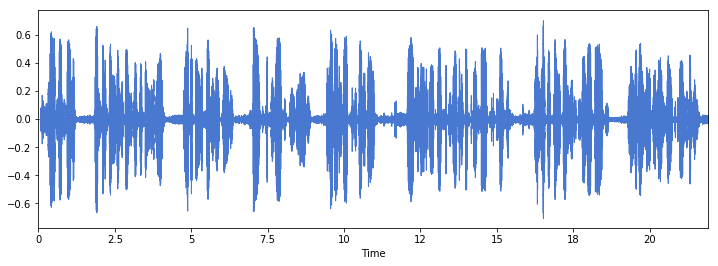

In [7]:
audio_path = './data/english1.mp3'
y, sr = librosa.load(audio_path)

plt.figure(figsize=(12,4))
librosa.display.waveplot(y, sr)
plt.show()

Here we focus on MFCC features. Some other [features](https://librosa.github.io/librosa/feature.html#feature) can be also implemented.

MFCC stands for Mel-frequency cepstrum coefficients. The [Mel scale](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/) relates perceived frequency, or pitch, of a pure tone to its actual measured frequency. Humans are much better at discerning small changes in pitch at low frequencies than they are at high frequencies. Incorporating this scale makes our features match more closely what humans hear.

In [8]:
# Mel-frequency cepstrum coefficients
def make_librosa_mfcc(filename):    
    filename = os.path.join('./data', filename)
    y, sr = librosa.load(filename)
    mfcc_feat = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfcc_feat

In [11]:
# it is common to normalise mfcc values in speech recognition systems to lessen the influence of noise (c)Wiki
# change total number of samps for downsampled file to n_samps by trimming or zero-padding and standardize them
def make_standard_length(filename, n_samps=240000):
    filename = os.path.join('./data', filename)
    down_sig, rate = downsample(filename)
    normed_sig = librosa.util.fix_length(down_sig, n_samps)
    normed_sig = (normed_sig - np.mean(normed_sig))/np.std(normed_sig)
    return normed_sig

def make_normed_mfcc(filename, outrate=8000):
    filename = os.path.join('./data', filename)
    normed_sig = make_standard_length(filename)
    normed_mfcc_feat = mfcc(normed_sig, outrate)
    normed_mfcc_feat = normed_mfcc_feat.T
    return normed_mfcc_feat

This is how a Mel spectrogram looks like 

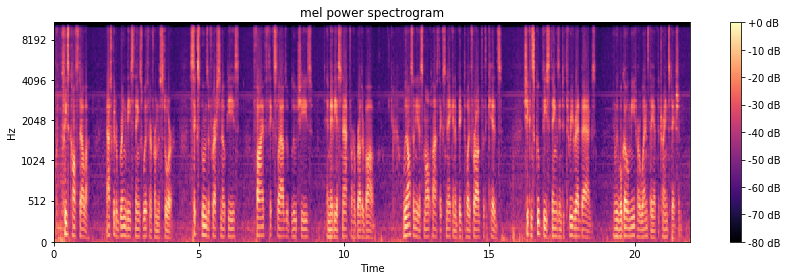

In [12]:
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

:o

In [ ]:
def generate_mfcc(Xnames):
    leng = len(Xnames)
    X_features = np.empty((leng, 30000))
    print('length', leng)
    for i in range(leng):
        temp = np.ravel(make_librosa_mfcc(Xnames[i]))
        X_features[i] = np.pad(temp, (0, 30000 - len(temp)), 'constant', constant_values=0)
        print(i)
    return X_features

# ~ 13min
X_features = generate_mfcc(Xnames)

## Dimension reduction with PCA and t-SNE

mainly to visualize features

In [ ]:
import sklearn
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.patheffects as PathEffects


#Here is a utility function used to display the transformed dataset
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    countries = ['usa', 'uk']
    for i in range(2):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, countries[i], fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

# #Here is the result.
# tsne_result = TSNE().fit_transform(X_features, y)
# scatter(tsne_result, y)
# plt.savefig('tsne-generated.png', dpi=120)


it may be useful to try PCA before sending to t-SNE algorithm

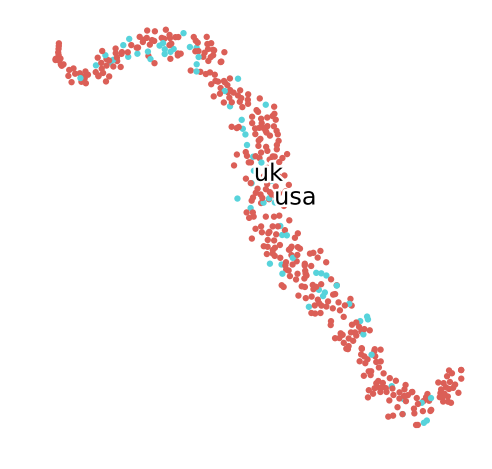

In [49]:
from sklearn.decomposition import PCA


pca = PCA(n_components=50)
pca_result = pca.fit_transform(X_features)


tsne_pca = TSNE().fit_transform(pca_result, y)
scatter(tsne_pca, y)
plt.savefig('tsne-pca-generated.png', dpi=120)

would be fun to plot other languages alongside

## Build Neural Net

By now we've scrapped 69 british and 394 america voice samples from the internet and extracted mfcc features from them. Now we can try to make a neural network for the recognition purposes. Some similar works on this problem found in the Internet:

https://github.com/dwww2012/Accent-Classifier

https://www.analyticsvidhya.com/blog/2017/08/audio-voice-processing-deep-learning/